# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook computes predicted expression correlations between all genes in the MultiPLIER models.

It has specicfic parameters for papermill (see under `Settings` below).
It can be configured to run on a single chromosome to run in parallel.

This notebook is not directly run. See README.md.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from random import sample, seed
import warnings
from pathlib import Path
import pickle
import traceback

import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene

# Settings

In [3]:
# a cohort name (it could be something like UK_BIOBANK, etc)
COHORT_NAME = None

# reference panel such as 1000G or GTEX_V8
REFERENCE_PANEL = "GTEX_V8"

# predictions models such as MASHR or ELASTIC_NET
EQTL_MODEL = "MASHR"

# this is the default value used in S-MultiXcan to select the
# top principal components of the expression correlation matrix
SMULTIXCAN_CONDITION_NUMBER = 30

# specifies a single chromosome value
CHROMOSOME = None

# If True, computes the correlation between closeby genes only;
# otherwise, it computes correlations for all genes in a chromosome
COMPUTE_CORRELATIONS_WITHIN_DISTANCE = False

# if True, then it will continue if a gene pair correlation fails,
# printing the warning/error for debugging. If False, any warning/error
# will be thrown
DEBUG_MODE = False

# output dir
OUTPUT_DIR_BASE = None

In [4]:
# Parameters
COHORT_NAME = "asthma_only"
CHROMOSOME = 2
OUTPUT_DIR_BASE = "/opt/data/projects/asthma-copd/results/gls_phenoplier"


In [5]:
assert COHORT_NAME is not None and len(COHORT_NAME) > 0, "A cohort name must be given"

COHORT_NAME = COHORT_NAME.lower()
display(f"Cohort name: {COHORT_NAME}")

'Cohort name: asthma_only'

In [6]:
assert (
    REFERENCE_PANEL is not None and len(REFERENCE_PANEL) > 0
), "A reference panel must be given"

display(f"Reference panel: {REFERENCE_PANEL}")

'Reference panel: GTEX_V8'

In [7]:
assert (
    EQTL_MODEL is not None and len(EQTL_MODEL) > 0
), "A prediction/eQTL model must be given"

EQTL_MODEL_FILES_PREFIX = conf.PHENOMEXCAN["PREDICTION_MODELS"][f"{EQTL_MODEL}_PREFIX"]
display(f"eQTL model: {EQTL_MODEL}) / {EQTL_MODEL_FILES_PREFIX}")

'eQTL model: MASHR) / mashr_'

In [8]:
assert (
    SMULTIXCAN_CONDITION_NUMBER is not None and SMULTIXCAN_CONDITION_NUMBER > 0
), "The S-MultiXcan condition number (positive integer) must be given"

display(f"S-MultiXcan condition number: {SMULTIXCAN_CONDITION_NUMBER}")

'S-MultiXcan condition number: 30'

In [9]:
assert CHROMOSOME is not None and (
    1 <= CHROMOSOME <= 22
), "You have to select one chromosome (format: number between 1 and 22)"

# CHROMOSOME = str(CHROMOSOME)
display(f"Working on chromosome {CHROMOSOME}")

'Working on chromosome 2'

In [10]:
display(f"Compute correlation within distance {COMPUTE_CORRELATIONS_WITHIN_DISTANCE}")

'Compute correlation within distance False'

In [11]:
assert (
    OUTPUT_DIR_BASE is not None and len(OUTPUT_DIR_BASE) > 0
), "Output directory path must be given"

OUTPUT_DIR_BASE = (
    Path(OUTPUT_DIR_BASE)
    / "gene_corrs"
    / COHORT_NAME
    # / REFERENCE_PANEL.lower()
    # / EQTL_MODEL.lower()
).resolve()

OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/asthma_only'

# Load data

## GWAS variants

In [12]:
with open(OUTPUT_DIR_BASE / "gwas_variant_ids.pkl", "rb") as handle:
    gwas_variants_ids_set = pickle.load(handle)

In [13]:
len(gwas_variants_ids_set)

8578486

In [14]:
list(gwas_variants_ids_set)[:5]

['chr2_42045844_A_G_b38',
 'chr2_232386664_A_G_b38',
 'chr20_62801579_G_T_b38',
 'chr4_118860748_A_G_b38',
 'chr17_19488527_G_A_b38']

## S-PrediXcan tissue models

In [15]:
spredixcan_genes_models = pd.read_pickle(OUTPUT_DIR_BASE / "gene_tissues.pkl")

In [16]:
spredixcan_genes_models.shape

(6443, 5)

In [17]:
spredixcan_genes_models.head()

,gene_name,tissue,n_tissues,n_snps_used_sum,n_snps_in_model_sum
gene_id,,,,,
ENSG00000000419,DPM1,"(Brain_Substantia_nigra, Brain_Hypothalamus)",2,2,2
ENSG00000000938,FGR,"(Colon_Sigmoid, Skin_Sun_Exposed_Lower_leg, Br...",36,40,40
ENSG00000000971,CFH,"(Artery_Coronary, Colon_Sigmoid, Skin_Sun_Expo...",34,44,44
ENSG00000001084,GCLC,"(Artery_Coronary, Skin_Sun_Exposed_Lower_leg, ...",32,46,46
ENSG00000001167,NFYA,"(Artery_Coronary, Colon_Sigmoid, Skin_Sun_Expo...",40,47,48


In [18]:
assert spredixcan_genes_models.index.is_unique

## Gene info

In [19]:
genes_info = pd.read_pickle(OUTPUT_DIR_BASE / "genes_info.pkl")

In [20]:
genes_info.shape

(6443, 7)

In [21]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,UBE4B,ENSG00000130939,1,1p36.22,10032832,10181239,148407
1,STX18,ENSG00000168818,4,4p16.2,4415742,4542346,126604
2,DNM2,ENSG00000079805,19,19p13.2,10718079,10833488,115409
3,PLD1,ENSG00000075651,3,3q26.31,171600404,171810950,210546
4,ANKRD55,ENSG00000164512,5,5q11.2,56099680,56233330,133650


# Compute correlations

In [22]:
output_dir = OUTPUT_DIR_BASE / "by_chr"
output_dir.mkdir(exist_ok=True, parents=True)
output_file = output_dir / f"gene_corrs-chr{CHROMOSOME}.pkl"
display(output_file)

PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/asthma_only/by_chr/gene_corrs-chr2.pkl')

In [23]:
warnings.filterwarnings("error")

In [24]:
# standard checks
all_chrs = genes_info["chr"].dropna().unique()
assert all_chrs.shape[0] == 22

# select chromosome given by the user
assert CHROMOSOME in all_chrs

In [25]:
# run only on the chromosome specified
all_chrs = [CHROMOSOME]
genes_chr = genes_info[genes_info["chr"] == CHROMOSOME]

# For testing purposes
# genes_chr = genes_chr.sample(n=20)

print(f"Number of genes in chromosome: {genes_chr.shape[0]}", flush=True)

Number of genes in chromosome: 444


In [26]:
# sort genes by starting position to make visualizations better later
genes_chr = genes_chr.sort_values("start_position")

In [27]:
gene_chr_objs = [Gene(ensembl_id=gene_id) for gene_id in genes_chr["id"]]

In [28]:
n = len(gene_chr_objs)
# diagonal elements + upper triangular matrix
n_comb = n + int(n * (n - 1) / 2.0)
print(f"Number of gene combinations: {n_comb}", flush=True)

Number of gene combinations: 98790


In [29]:
gene_corrs = []
gene_corrs_data = np.full(
    (n, n),
    np.nan,
    dtype=np.float64,
)

i = 0
with tqdm(ncols=100, total=n_comb) as pbar:
    for gene1_idx in range(0, len(gene_chr_objs)):
        gene1_obj = gene_chr_objs[gene1_idx]
        gene1_tissues = spredixcan_genes_models.loc[gene1_obj.ensembl_id, "tissue"]

        for gene2_idx in range(gene1_idx, len(gene_chr_objs)):
            gene2_obj = gene_chr_objs[gene2_idx]
            gene2_tissues = spredixcan_genes_models.loc[gene2_obj.ensembl_id, "tissue"]

            pbar.set_description(f"{gene1_obj.ensembl_id} / {gene2_obj.ensembl_id}")

            try:
                r = gene1_obj.get_ssm_correlation(
                    other_gene=gene2_obj,
                    tissues=gene1_tissues,
                    other_tissues=gene2_tissues,
                    snps_subset=gwas_variants_ids_set,
                    condition_number=SMULTIXCAN_CONDITION_NUMBER,
                    reference_panel=REFERENCE_PANEL,
                    model_type=EQTL_MODEL,
                    use_within_distance=COMPUTE_CORRELATIONS_WITHIN_DISTANCE,
                )

                if r is None:
                    # if r is None, it's very likely because:
                    #  * one of the genes has no prediction models
                    #  * all the SNPs predictors for the gene are not present in the reference
                    #    panel

                    r = 0.0

                gene_corrs.append(r)

                gene_corrs_data[gene1_idx, gene2_idx] = r
                gene_corrs_data[gene2_idx, gene1_idx] = r
            except Warning as e:
                if not DEBUG_MODE:
                    raise e

                print(
                    f"RuntimeWarning for genes {gene1_obj.ensembl_id} and {gene2_obj.ensembl_id}",
                    flush=True,
                )
                print(traceback.format_exc(), flush=True)

                gene_corrs.append(np.nan)
            except Exception as e:
                if not DEBUG_MODE:
                    raise e

                print(
                    f"Exception for genes {gene1_obj.ensembl_id} and {gene2_obj.ensembl_id}",
                    flush=True,
                )
                print(traceback.format_exc(), flush=True)

                gene_corrs.append(np.nan)

            pbar.update(1)

# create a pandas series
gene_corrs_flat = pd.Series(gene_corrs)

# save
# FIXME: consider saving only the condenced matrix here. See here for
# more details: https://github.com/greenelab/phenoplier/pull/38#discussion_r634600813
# gene_corrs_data = squareform(np.array(gene_corrs, dtype=np.float64))
# np.fill_diagonal(gene_corrs_data, 1.0)

gene_chr_ids = [g.ensembl_id for g in gene_chr_objs]
gene_corrs_df = pd.DataFrame(
    data=gene_corrs_data,
    index=gene_chr_ids,
    columns=gene_chr_ids,
)

output_dir.mkdir(exist_ok=True, parents=True)
display(output_file)

gene_corrs_df.to_pickle(output_file)

ENSG00000188389 / ENSG00000188389: 100%|████████████████████| 98790/98790 [1:07:46<00:00, 24.29it/s]


PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gene_corrs/asthma_only/by_chr/gene_corrs-chr2.pkl')

# Testing

In [30]:
gene_corrs_df.shape

(444, 444)

In [31]:
gene_corrs_df.head()

,ENSG00000143727,ENSG00000115705,ENSG00000130508,ENSG00000182551,ENSG00000171865,ENSG00000171863,ENSG00000134326,ENSG00000134321,ENSG00000115738,ENSG00000134313,...,ENSG00000068024,ENSG00000130414,ENSG00000063660,ENSG00000178623,ENSG00000115687,ENSG00000168385,ENSG00000006607,ENSG00000168393,ENSG00000180902,ENSG00000188389
ENSG00000143727,1.000000,0.008300,0.008055,0.003016,0.008433,0.003120,0.006102,0.005202,0.007668,0.004094,...,0.006509,0.002932,0.007425,0.002857,0.007020,0.004770,0.004884,0.007674,0.003961,0.010282
ENSG00000115705,0.008300,1.000000,0.016309,0.010477,0.012934,0.011270,0.008908,0.007999,0.011196,0.012927,...,0.013428,0.004470,0.014350,0.010299,0.011892,0.009197,0.006806,0.008853,0.005419,0.012237
ENSG00000130508,0.008055,0.016309,1.000000,0.010977,0.008181,0.007399,0.010375,0.005571,0.009200,0.008443,...,0.013978,0.008134,0.011935,0.005437,0.009639,0.006198,0.007533,0.011918,0.006175,0.011120
ENSG00000182551,0.003016,0.010477,0.010977,1.000000,0.134368,0.223789,0.007137,0.008064,0.006583,0.010303,...,0.009493,0.008177,0.012193,0.007462,0.007738,0.005166,0.006390,0.006816,0.004762,0.006547
ENSG00000171865,0.008433,0.012934,0.008181,0.134368,1.000000,0.115207,0.009295,0.005103,0.010320,0.006853,...,0.014043,0.008898,0.011080,0.009279,0.005953,0.006958,0.007522,0.009214,0.007200,0.009590


## Standard checks and stats

In [32]:
assert not gene_corrs_df.isna().any().any()

In [33]:
_min_val = gene_corrs_df.min().min()
display(_min_val)
assert _min_val >= -0.05

5.332538193318637e-08

In [34]:
_max_val = gene_corrs_df.max().max()  # this captures the diagonal
display(_max_val)
assert _max_val <= 1.05

1.0000000000000036

In [35]:
# check upper triangular values
# assert len(gene_corrs) == int(genes_chr.shape[0] * (genes_chr.shape[0] - 1) / 2)

In [36]:
gene_corrs_flat.describe()

count    9.879000e+04
mean     1.163999e-02
std      7.016210e-02
min      5.332538e-08
25%      3.637434e-03
50%      5.631749e-03
75%      7.924846e-03
max      1.000000e+00
dtype: float64

In [37]:
gene_corrs_quantiles = gene_corrs_flat.quantile(np.arange(0, 1, 0.05))
display(gene_corrs_quantiles)

0.00    5.332538e-08
0.05    1.454093e-03
0.10    2.158828e-03
0.15    2.708528e-03
0.20    3.192975e-03
0.25    3.637434e-03
0.30    4.061170e-03
0.35    4.460517e-03
0.40    4.850188e-03
0.45    5.238725e-03
0.50    5.631749e-03
0.55    6.031403e-03
0.60    6.452915e-03
0.65    6.899359e-03
0.70    7.387566e-03
0.75    7.924846e-03
0.80    8.557658e-03
0.85    9.304504e-03
0.90    1.029370e-02
0.95    1.191185e-02
dtype: float64

## Positive definiteness

In [38]:
# print negative eigenvalues
eigs = np.linalg.eigvals(gene_corrs_df.to_numpy())
display(len(eigs[eigs < 0]))
display(eigs[eigs < 0])

0

array([], dtype=float64)

In [39]:
try:
    chol_mat = np.linalg.cholesky(gene_corrs_df.to_numpy())
    cov_inv = np.linalg.inv(chol_mat)
    print("Works!")
except Exception as e:
    print(f"Cholesky decomposition failed: {str(e)}")

Works!


In [40]:
try:
    # decomposition used by statsmodels.GLS
    cholsigmainv = np.linalg.cholesky(np.linalg.inv(gene_corrs_df.to_numpy())).T
    print("Works!")
except Exception as e:
    print(f"Cholesky decomposition failed (statsmodels.GLS): {str(e)}")

Works!


## Plot: distribution

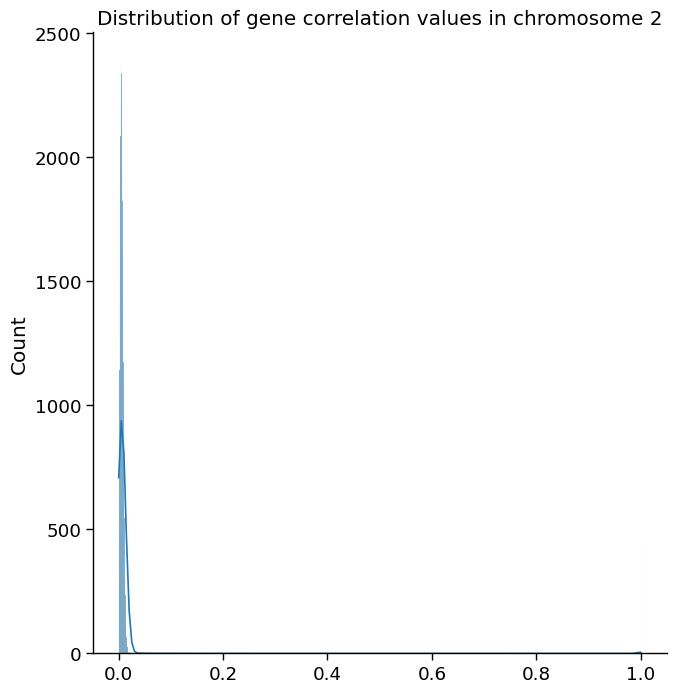

In [41]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(gene_corrs_flat, kde=True, height=7)
    g.ax.set_title(
        f"Distribution of gene correlation values in chromosome {CHROMOSOME}"
    )

## Plot: heatmap

In [42]:
vmin_val = min(0.00, gene_corrs_quantiles[0.10])
vmax_val = max(0.05, gene_corrs_quantiles[0.90])
display(f"{vmin_val} / {vmax_val}")

'0.0 / 0.05'

Text(0.5, 1.0, 'Gene correlations in chromosome 2')

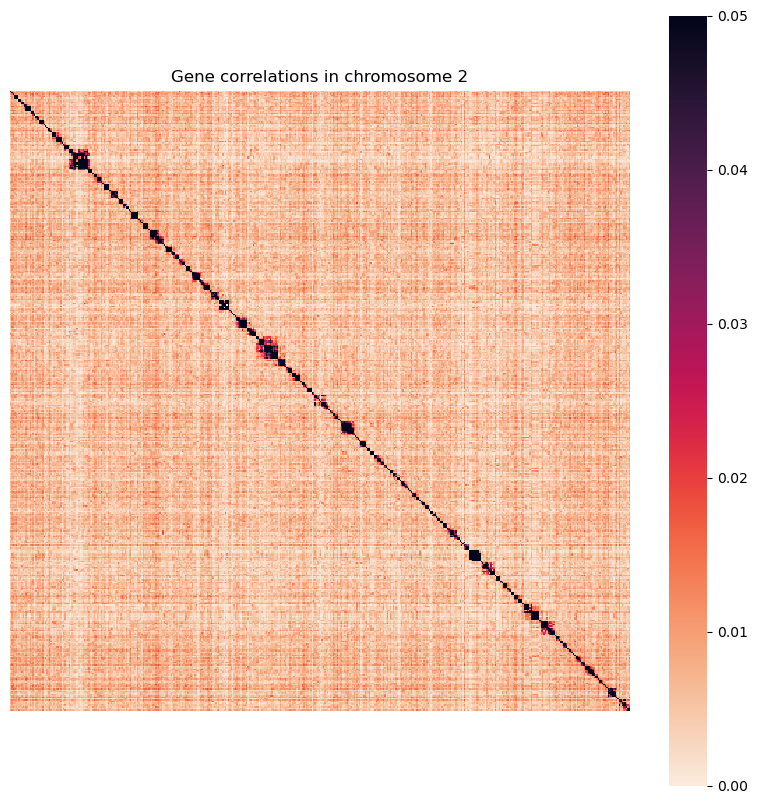

In [43]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    gene_corrs_df,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="rocket_r",
    ax=ax,
)
ax.set_title(f"Gene correlations in chromosome {CHROMOSOME}")